# Dragon Diffusion

In [ ]:
# | export
from __future__ import annotations
import math, random, torch, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, shutil, os, gzip, pickle, re, copy
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
from functools import partial
import fastcore.all as fc
from glob import glob

from torch import tensor, nn, optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from diffusers import UNet2DModel
from torch.utils.data import DataLoader, default_collate
from torch.nn import init

from einops import rearrange
from fastprogress import progress_bar
from PIL import Image
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

from dataclasses import dataclass
from diffusers import LMSDiscreteScheduler, UNet2DConditionModel, AutoencoderKL, DDIMScheduler
from transformers import AutoTokenizer, CLIPTextModel
from diffusers.utils import BaseOutput

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.utils import BaseOutput, deprecate
from diffusers.schedulers.scheduling_utils import SchedulerMixin

from dragon_diffusion.core import *
from dragon_diffusion.masks import *
from dragon_diffusion.nulltext import *
from dragon_diffusion.utils import *

Okay, so how is this gonna work? Rough outline:

1. Invert the image into latent space with DDIM inversion
2. Set up attention control
3. Calculate masks
4. Split into two branches and run edit optimisation
    - Original ("orig") branch — reconstruct the original image using null text inversion and save the KV attention matrices
    - Edit branch — using attention control, guide the image editing with a loss function

<Axes: >

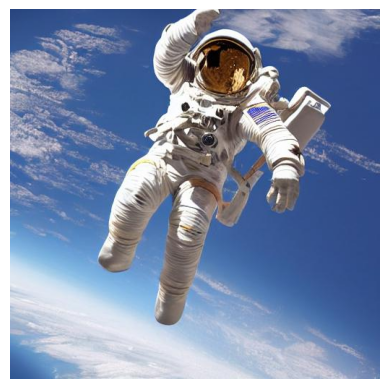

In [ ]:
img_path = '/home/astronaut.jpg'
img = load_img(img_path, 512, 512, return_tensor=True)
show_image(img)

In [ ]:
model = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='unet').cuda()
tokenizer = AutoTokenizer.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='vae').to('cuda')

In [ ]:
ddim_scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

#### Step 1 - calculate masks

In the final implementation, need to be able to calculate a mask, or accept a mask tensor. I'm going to use DiffEdit here, but SAM works fine too. The advantage of DiffEdit is that it's usable just by changing the prompt, rather than faffing around with a point.

/home/libs/dragon_diffusion/dragon_diffusion/masks.py:126: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (1, model.in_channels, height // 8, width // 8)


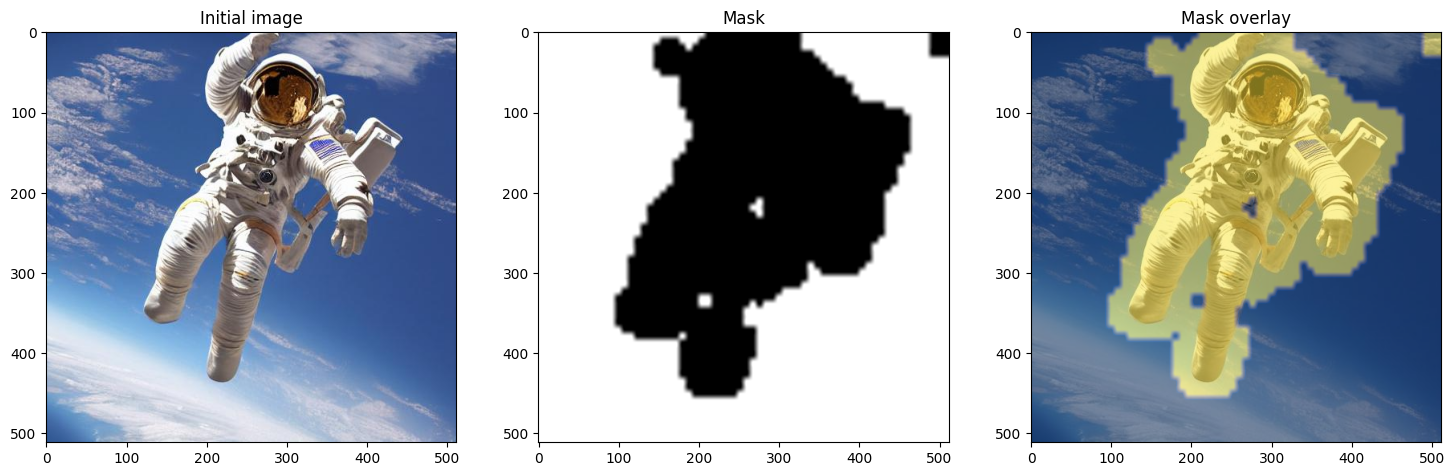

In [ ]:
edit_text = 'a goat floating above earth'
ref_text = 'an astronaut floating above earth'
mspace = ModelNamespace(model, scheduler, vae, tokenizer, text_encoder)
diffedit_mask(edit_text, ref_text, img_path, mspace, seed=42, erosion_it=8, dilation_it=14)

#### Step 2 - null text inversion

Handily, we've already done that. Note that in the final implementation, we'll only do null text optimisation in the event that it isn't a generated image — if we're generating the image as well, we'll just use the actual latent intermediates calculated across diffusion steps.

In [ ]:
prompt = 'an astronaut floating in space'
uncond_embeddings = get_embeddings("", text_encoder, tokenizer, concat_unconditional=False, device='cuda')
cond_embeddings = get_embeddings(prompt, text_encoder, tokenizer, concat_unconditional=False, device='cuda')

In [ ]:
height, width = 512, 512
latents = encode_img(img_path, height, width, vae) ## start from existing image
steps = 50
device = 'cuda'
ddim_scheduler.set_timesteps(steps)
all_latents = ddim_inversion(latents, cond_embeddings, ddim_scheduler, model)
print("DDIM inversion complete.")

DDIM inversion complete.


In [ ]:
embeddings = torch.cat([cond_embeddings, uncond_embeddings])
z_T, all_null_texts = null_text_inversion(model, ddim_scheduler, all_latents, embeddings, inner_steps=10)
print('Null text inversion complete')

Null text inversion complete


Now we have a trajectory of unconditional embeddings which we can use to reconstruct the original image. Using this, we can run a diffusion loop starting from a random point in latent space and get back the original image.

#### Step 3 - set up attention control

In [ ]:
class AttnStorage:
    def __init__(self): self.storage = {}
    def __call__(self, name, key, value, emb_type):
        if not emb_type in self.storage: self.storage[emb_type] = {}
        if not name in self.storage[emb_type]: self.storage[emb_type][name] = {}
        self.storage[emb_type][name]['key'] = key
        self.storage[emb_type][name]['value'] = value
        # self.storage[emb_type][name]['attention'] = attention_probs
    def flush(self): self.storage = {}

In [ ]:
from diffusers.models.attention_processor import AttnProcessor, Attention

In [ ]:
class CustomAttnProcessor(AttnProcessor):
    def __init__(self, attn_storage, name=None): 
        fc.store_attr()
        self.store_attention = False
        self.inject_attention = False
    def set_attention(self, store, inject, emb_type='cond'): 
        self.store_attention = store
        self.emb_type = emb_type
        self.inject_attention = inject
    def __call__(self, attn: Attention, hidden_states, encoder_hidden_states=None, attention_mask=None):
        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)
     
        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)   
        
        if self.store_attention: self.attn_storage(self.name, key, value, self.emb_type) ## store key and value matrices
        
        if self.inject_attention: ## inject corresponding key and value matrices
            key = self.attn_storage.storage[self.emb_type][self.name]['key']
            value = self.attn_storage.storage[self.emb_type][self.name]['value']
            # attention_probs = self.attn_storage.storage[self.emb_type][self.name]['attention']
        
        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        attention_probs.requires_grad_(True)
        
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)
        
        return hidden_states

In [ ]:
# set up the custom attn processor and use to replace standard model processors
# note that this is only done for self-attention blocks in the decoder
storage = AttnStorage()
processor = partial(CustomAttnProcessor, storage)
attn_dict = get_attn_dict(processor, model, attention_type='attn1', location='decoder')
model.set_attn_processor(attn_dict)
print("Attention processors set.")

Attention processors set.


In [ ]:
# feature hooks
feat_layers = [1,2]
hooks = [Hook(model.up_blocks[i], get_features) for i in feat_layers]
print('Hooks created.')

Hooks created.


#### Step 4 - editing optimisation loop

In each iteration, we are extracting features from internal layers of the model. These features are smaller than the output latents — in order to use a mask with them, we need to be able to scale the mask up and down. The `local_resize` function makes this possible, through interpolation followed by expansion/center cropping. There is a `binarise` option to retain the binary characteristics of a mask.

In [ ]:
def local_resize(image, target_size, binarise=False):
    
    if len(image.shape) == 3: image = image.unsqueeze(0)
    interpolated_image = F.interpolate(image, size=target_size, mode='bilinear', align_corners=False)
    original_size = image.shape[-1]
    if target_size > original_size:
        # Center crop
        crop_size = original_size
        cropped_image = interpolated_image[
            :,
            :,
            (target_size - crop_size) // 2: (target_size + crop_size) // 2,
            (target_size - crop_size) // 2: (target_size + crop_size) // 2
        ]
        if binarise: 
            cropped_image[cropped_image > 0] = 1
            cropped_image = cropped_image.int()
        return cropped_image
    else:
        # Center expand
        padding = (original_size - target_size) // 2
        expanded_image = F.pad(interpolated_image, (padding, padding, padding, padding), mode='constant', value=0)
        if binarise: 
            expanded_image[expanded_image > 0] = 1
            expanded_image = expanded_image.int()
        return expanded_image

In [ ]:
def load_mask(mask_path, height, width, device='cpu'):
    mask = load_img(mask_path, height, width, return_tensor=True, device=device)
    mask[mask > 0] = 1
    return mask

We can visualise what this function does:

In [ ]:
mask_path = '/home/sam_mask.jpg'
height, width = 512, 512
mask = load_mask(mask_path, height//8, width//8) # [64,64] latent size
mask_small = local_resize(mask, height//16, binarise=True)
mask_big = local_resize(mask, height//4, binarise=True)

In [ ]:
mask_path = '/home/monalisa.png'
height, width = 512, 512
mask = load_img(mask_path, height//8, width//8, return_tensor=True) # [64,64] latent size
mask_small = local_resize(mask, height//16)
mask_big = local_resize(mask, height//4)

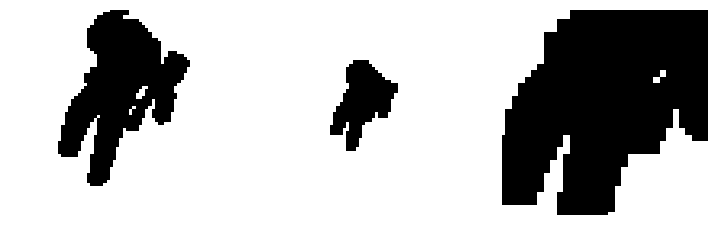

In [ ]:
show_images([mask, mask_small[0], mask_big[0]], nrows=1, ncols=3)

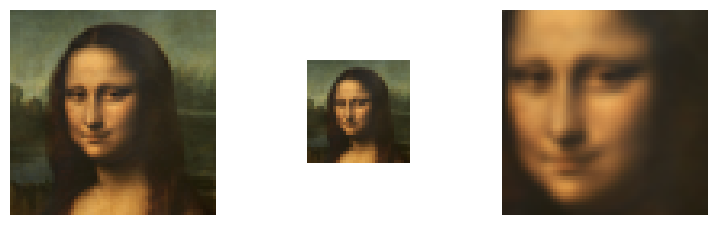

In [ ]:
show_images([mask, mask_small[0], mask_big[0]], nrows=1, ncols=3)

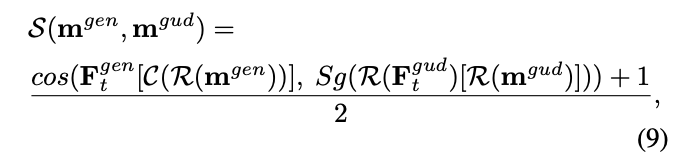

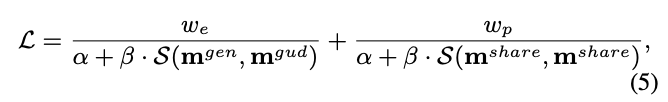

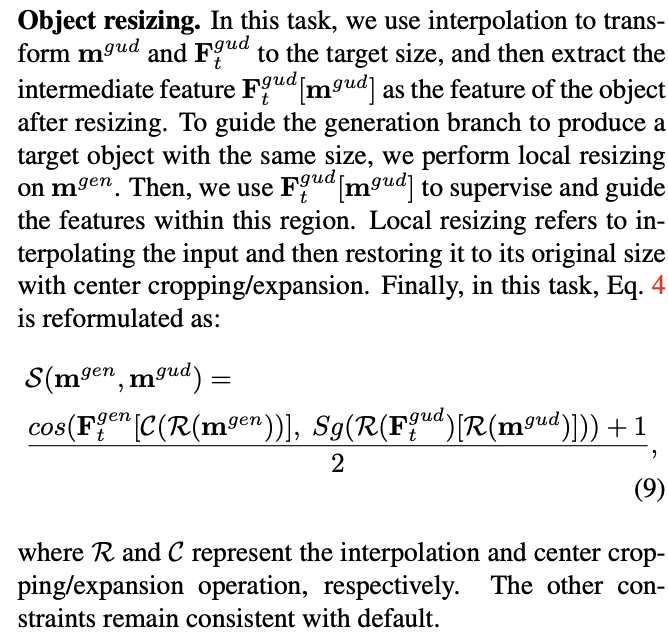

In [ ]:
ddim_scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')
scheduler_2 = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

In [ ]:
all_null_texts.append(uncond_embeddings)

In [ ]:
steps = 50
ddim_scheduler.set_timesteps(steps)
scheduler_2.set_timesteps(steps)
device = 'cuda'
orig_latents, edit_latents = z_T.clone().detach().to(device), z_T.clone().detach()
edit_latents = nn.Parameter(edit_latents).detach().to(device)
guidance1, guidance2 = 0, 0
lr = 1e-4
eta = 8e2

mask_path = '/home/sam_mask.jpg'
feat_1_mask = load_mask(mask_path, height//16, width//16)
feat_2_mask = load_mask(mask_path, height//8, width//8)
masks = (feat_1_mask.to(device), feat_2_mask.to(device))

for i, t in enumerate(progress_bar(ddim_scheduler.timesteps, leave=False, comment='editing image...')):
    
    t = t.long()
    
    ##### (1) Reconstruction path #####
    
    latent_model_input = ddim_scheduler.scale_model_input(orig_latents, t) ## orig_latents
    with torch.no_grad():
        uncond_embeddings_null = all_null_texts[i].to(device)
        
        # store attention for uncond pred
        prepare_attention(model, storage, set_store=True, set_inject=False, emb_type='uncond')
        uncond = model(latent_model_input, t, encoder_hidden_states=uncond_embeddings_null).sample

        # store attention for cond pred separately
        prepare_attention(model, storage, set_store=True, set_inject=False, emb_type='cond')
        cond = model(latent_model_input, t, encoder_hidden_states=cond_embeddings).sample
        
        # get features
        f_orig = tuple([h.feats for h in hooks])
    
    # prediction for reconstructed image, based on null text embeddings
    orig_noise_pred = uncond + guidance1 * (cond - uncond)
    orig_latents = ddim_scheduler.step(orig_noise_pred, t, orig_latents).prev_sample
    
    
    ##### (2) Editing path #####
    
    edit_latents.requires_grad_(True)
    edit_latents.retain_grad()
    
    latent_model_input = scheduler_2.scale_model_input(edit_latents, t) ## edit_latents
    
    # inject uncond attention
    prepare_attention(model, storage, set_store=False, set_inject=True, emb_type='uncond')
    uncond = model(latent_model_input, t, encoder_hidden_states=uncond_embeddings).sample
    
    # inject cond attention
    prepare_attention(model, storage, set_store=False, set_inject=True, emb_type='cond')
    cond = model(latent_model_input, t, encoder_hidden_states=cond_embeddings).sample
    
    # get features
    f_edit = [h.feats for h in hooks]
    
    # classifier-free guidance
    edit_noise_pred = uncond + guidance2 * (cond - uncond)
    
    # resize the mask according to each feature size and 
    # isolate the masked area. Remember that there are *multiple*
    # feature layers being used, so this is a bit annoying
    masks_resize = [local_resize(m, m.shape[-1]*2, binarise=True) for m in masks] ## resize the mask
    f_orig_resize = [local_resize(f, f.shape[-1]*2) for f in f_orig]              ## resize the features
    m_orig = [m*f for m,f in zip(masks_resize, f_orig_resize)]                    ## extract the original features within the mask
    m_share_orig = [~m*f for m,f in zip(masks_resize, f_orig)]             ## extract the original features outside the mask
    # f_edit_resize = [local_resize(f, f.shape[-1]*2) for f in f_edit]              
    m_edit = [m*f for m,f in zip(masks_resize, f_edit)]                           ## extract the edited features inside the mask
    m_share_edit = [~m*f for m,f in zip(masks_resize, f_edit)]                    ## extract the edited features outside the mask
    
    # do loss function
    loss = resize_loss(m_orig, m_edit, m_share_orig, m_share_edit)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(edit_latents, max_norm=0.1)
    edit_noise_pred += eta*(masks_resize[1]*edit_latents.grad)
    edit_latents = scheduler_2.step(edit_noise_pred.detach(), t, edit_latents.detach()).prev_sample
    storage.flush()
    
orig_latents = 1 / 0.18215 * orig_latents
edit_latents = 1 / 0.18215 * edit_latents

with torch.no_grad():
    edit_img = decode_img(edit_latents, vae)
    orig_img = decode_img(orig_latents, vae)
    
print('Complete')

Complete


In [ ]:
image = load_img(img_path, 512, 512)

In [ ]:
def eudistance(tensor1, tensor2):
    diff = (tensor1 - tensor2) ** 2
    sum_diff = np.sum(diff, axis=(1,2))
    distances = np.sqrt(sum_diff)
    return distances

In [ ]:
# equation 5 and 9
def resize_loss(m_orig, m_edit, m_share_orig, m_share_edit, edit_weight=8, consistency_weight=0.5, alpha1=0.1, beta1=1, alpha2=0.3, beta2=0.2):
    loss = []
    for mo, me, mso, mse in zip(m_orig, m_edit, m_share_orig, m_share_edit):
        cross_sim = (F.cosine_similarity(me, mo).clip(-1,1) + 1) / 2
        share_sim = (F.cosine_similarity(mse.float(), mso.float()).clip(-1,1) + 1) / 2
        t1 = edit_weight / (alpha1 + beta1*cross_sim)
        t2 = consistency_weight / (alpha2 + beta2*share_sim)
        loss.append((t1+t2).mean())
    return loss[0] + loss[1]

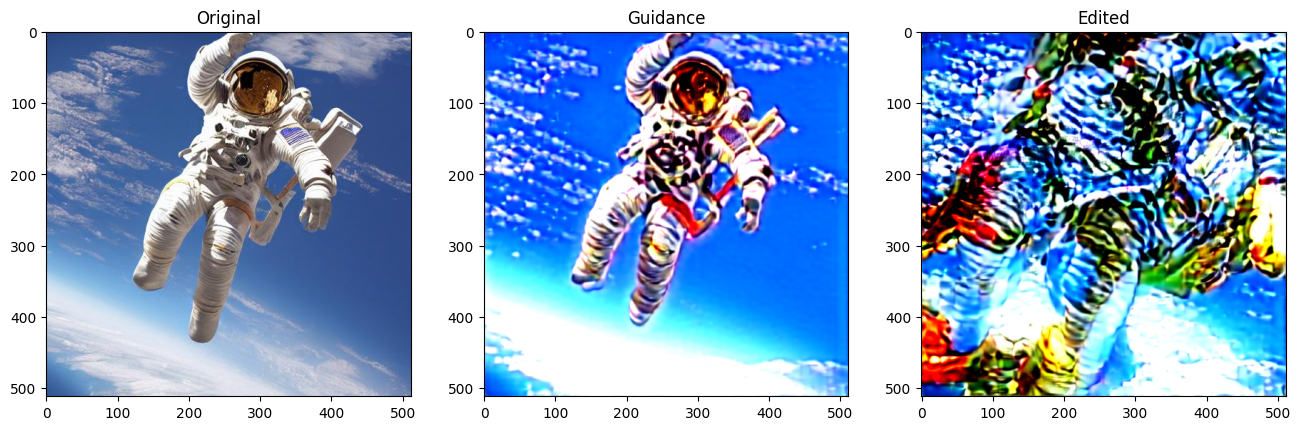

In [ ]:
# edit_weight=8, consistency_weight=0.5, alpha=0.2, beta=2
fig, ax = plt.subplots(1,3,figsize=(16,8))
for i, (img, title) in enumerate(zip([image, orig_img, edit_img], ["Original", "Guidance", "Edited"])):
    ax[i].imshow(img)
    ax[i].set_title(title)

This seems to be working (somewhat). Notably, the size of the grad impacts the kind of changes. I can see the astronaut and I can see that he is 2x larger and still in proportion. *Structurally* it seems on point. It's just that everything else sucks. I have tried grad tuning in case this was just grad overload but that doesn't seem to be the problem. I haven't tried every possible value but I've explored the space. I don't know if this is a red herring or a hint that I'm on the right track.

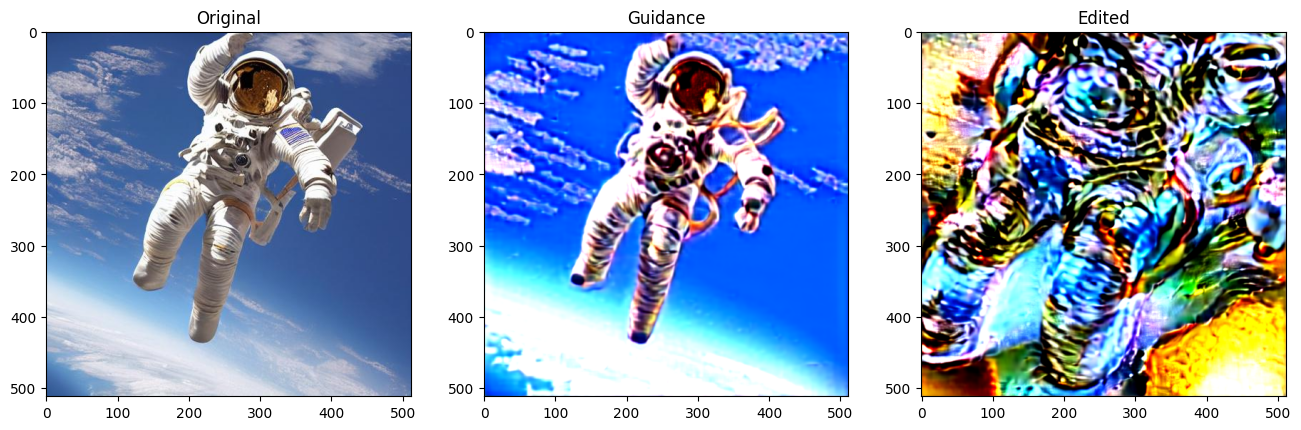

In [ ]:
# eta 5e3, edit_weight=1, consistency_weight=2, alpha=0.1, beta=0.5
fig, ax = plt.subplots(1,3,figsize=(16,8))
for i, (img, title) in enumerate(zip([image, orig_img, edit_img], ["Original", "Guidance", "Edited"])):
    ax[i].imshow(img)
    ax[i].set_title(title)

<matplotlib.legend.Legend>

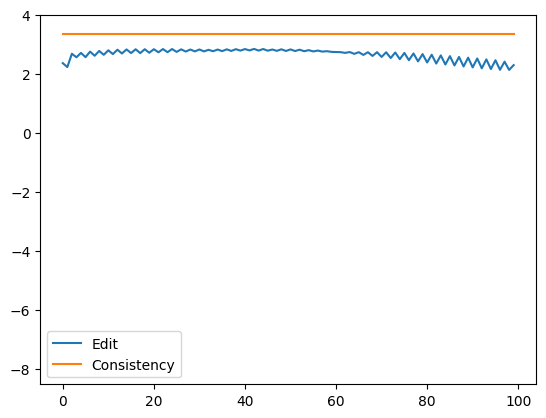

In [ ]:
# eta 5e3, edit_weight=1, consistency_weight=2, alpha=0.1, beta=0.5
y = t1s+t2s
ymin, ymax = min(y) - 5 * min(y), max(y) + 0.2 * max(y)
plt.plot([t.detach().cpu().numpy() for t in t1s], label="Edit")
plt.plot([t.detach().cpu().numpy() for t in t2s], label="Consistency")
plt.ylim([ymin.detach().cpu().numpy(), ymax.detach().cpu().numpy()])
plt.legend()

Things to try:

1. ~Use the null text uncond embeddings for the edited image?~
2. ~Inject attention for the uncond prediction in the editing path?~
3. ~Separately inject attention from the uncond and cond strands?~ Helps a bit
4. ~Check grad size. If small, inflate eta weight.~ eta needs to be much larger than a learning rate
5. Am I doing equation 6 correctly? Perhaps I need to factor the mask into the grads. Surely grads in the share mask should be 0.
6. ~Muck around with the hypers.~ Cannot find stable area
7. ~Separate alpha/beta for loss terms?~ No difference
8. ~Inject whole attention probs rather than key and value matrices~ Too constraining
9. ~Inject just the key | value matrix~
10. ~Just DDIM inversion?~
11. ~Add the gradient clip~
12.

Dragon Diffusion class

1. Enable calculation of mask, or accept a custom mask.
2. Enable generation of image, or accept an image.
3. If generated image, store the intermediate latents.
4. If input image, perform null text inversion.